Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

# TODO:
- min prime Age -> 0.38
- max prime Age -> 0.38
- Model Anwendung auf aktuelle Spieler
  - Bugfix bei individuellen SHAP Values -> DONE
- 136 NULLs in df_preprocessed -> DONE
- richtiges script :)
- nächster Spieler

In [337]:
HYPERTRAINING = False
CV = 5
SCORING = 'r2'
AUTO_FEATURE_SELECT = 'AUTO'
# forward eher schlecht
#'neg_mean_squared_error'   nope
#r2 sehr gut -> 0.45
# 'explained_variance'
# HUBER
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "offense_potential_forward_min_pot_min_prime"
SAVE_MODEL_NAME = EXPERIEMENT_NAME
RUN_NAME = None
TARGET_OVERALL = 80
MINDEST_POTENTIAL = 50
CENTRAL = 1
OFFENSE = 1

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackleshooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']

PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','Composure','Interceptions','Age',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'BallControl',  'SprintSpeed', 'Agility'
       'Reactions',  'ShotPower', 'Jumping',  'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  'HeadingAccuracy','prime_age']

PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','Composure','Interceptions',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'BallControl',  'SprintSpeed', 'Agility',
       'Reactions',  'ShotPower', 'Jumping',  'Strength',
        'Positioning', 'Vision','Age',
       'Penalties',  'HeadingAccuracy']


In [338]:
%load_ext autoreload
%autoreload 2

import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")

find_and_append_module_path()

import os
import warnings
from datetime import datetime
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

from prediction_prime_overall.src.prepare import (
    add_features_raw,
    select_features
)
from prediction_prime_overall.src.eval import (
    plot_feature_importance,
    plot_shap_summary,
    plot_auc_curves,
    log_metrics_in_mlflow_regression,
    log_metrics_in_mlflow,
    log_feature_list_as_artifact
)
import prediction_prime_overall.config as CONFIG
from prediction_prime_overall.src.utils import *


mlflow.set_tracking_uri("file:///"+CONFIG.MLFLOW)
mlflow.set_experiment(EXPERIEMENT_NAME)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
New current directory: c:\Users\Robert\Documents\Projekte\statsfaction


<Experiment: artifact_location='file:///c:\\Users\\Robert\\Documents\\Projekte\\statsfaction\\prediction_prime_overall\\data\\mlflow/319009839572348588', creation_time=1704286246816, experiment_id='319009839572348588', last_update_time=1704286246816, lifecycle_stage='active', name='offense_potential_forward_min_pot_min_prime', tags={}>

### Get Data


In [339]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(
  SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  

(SELECT *,Potential as max_potential FROM fifa WHERE Potential>={MINDEST_POTENTIAL})
GROUP BY ID
order by potential DESC;
"""



In [340]:


# Step 1: Establish a database connection
conn = sqlite3.connect(CONFIG.DATABASE)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = df_raw[~(df_raw.Agility.isna())]
df_raw = add_features_raw(df_raw)

df_raw.head()


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,league,club_prestige,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,None,NaN,95.0,24.0,94.0,RW,0,1,1.0,13.0
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,None,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,None,NaN,91.0,20.0,78.0,RW,0,1,1.0,35.0
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,None,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,None,NaN,90.0,21.0,81.0,RW,0,1,1.0,25.0


# 

In [341]:
df_raw[df_raw.index.get_level_values('ID')==239085].prime_age

ID      Name       FIFA
239085  E. Håland  2018    22.0
Name: prime_age, dtype: float64

In [342]:
# df_raw["Potential"] = df_raw.Potential.astype('float')
# df_raw["max_potential"] = df_raw.max_potential.astype('float')

In [343]:
df = df_raw.copy()

year_to_category = {2011: 'train', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'test', 2019: 'test', 2020: 'test', 2021: 'valid', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [344]:
df[df.prime_age>df.potential_age]

,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,club_prestige,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense,set
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,NaN,95.0,24.0,94.0,RW,0,1,1.0,13.0,train
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0,train
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0,train
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,NaN,90.0,21.0,81.0,RW,0,1,1.0,25.0,valid
255475,Antony,2021,20.0,20.0,https://cdn.sofifa.net/players/255/475/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,78.0,88.0,Ajax,https://cdn.sofifa.net/meta/team/629/30.png,€31M,...,NaN,88.0,22.0,82.0,RW,0,1,1.0,36.0,valid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183699,C. Henderson,2011,23.0,23.0,https://cdn.sofifa.net/players/183/699/11_60.png,New Zealand,https://cdn.sofifa.net/flags/nz.png,46.0,69.0,Mjällby,https://cdn.sofifa.net/meta/team/411/30.png,€0,...,NaN,69.0,28.0,61.0,RF,0,1,1.0,24.0,train
200555,Kang Soo Il,2011,22.0,22.0,https://cdn.sofifa.net/players/200/555/11_60.png,Korea Republic,https://cdn.sofifa.net/flags/kr.png,63.0,68.0,Incheon United,https://cdn.sofifa.net/meta/team/6922/30.png,€0,...,NaN,68.0,27.0,69.0,RF,0,1,1.0,31.0,train
155494,D. Plizga,2011,24.0,24.0,https://cdn.sofifa.net/players/155/494/11_60.png,Poland,https://cdn.sofifa.net/flags/pl.png,58.0,67.0,Zagłębie Lubin,https://cdn.sofifa.net/meta/team/1266/30.png,€0,...,NaN,67.0,25.0,68.0,RF,0,1,1.0,28.0,train


In [345]:
df = df[(df.central == CENTRAL)&(df.offense ==OFFENSE)]

# Training nur auf High Potentials
df = df[df.max_potential>MINDEST_POTENTIAL]

# nur Entwicklugnsfähige Spieler
BOOL_DEVELOPMENT_TIME = (df.prime_age-df.potential_age)>0

df = df[BOOL_DEVELOPMENT_TIME]
# df = df[df.PrimeOverall>df.Overall]
df = df[df.potential_age<23]

df['target'] = df.PrimeOverall


print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
66.0    184
67.0    171
68.0    171
70.0    171
65.0    170
69.0    167
63.0    163
64.0    161
71.0    130
73.0    127
62.0    126
72.0    123
61.0    110
60.0    109
74.0    107
75.0     90
58.0     79
59.0     77
76.0     74
78.0     68
77.0     53
56.0     49
55.0     48
54.0     40
57.0     39
79.0     33
80.0     29
53.0     22
81.0     22
82.0     18
83.0     13
50.0     13
84.0     12
52.0     11
51.0     10
86.0      4
87.0      3
89.0      3
92.0      2
90.0      2
88.0      2
91.0      1
85.0      1
47.0      1
Name: count, dtype: int64


In [346]:
df_overview = df[df.prime_age>df.potential_age][["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]]
df_overview.head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
186405,F. di Santo,2011,21.0,21.0,27.0,90.0,90.0,74.0,77.0,77.0,train,ST
199266,Ji Dong Won,2011,19.0,19.0,22.0,89.0,89.0,66.0,71.0,71.0,train,ST
240833,Y. Moukoko,2023,17.0,17.0,18.0,88.0,88.0,69.0,77.0,77.0,valid,ST
231677,M. Rashford,2017,18.0,18.0,25.0,88.0,88.0,76.0,84.0,84.0,train,ST
225719,K. Iheanacho,2017,19.0,19.0,24.0,88.0,88.0,74.0,78.0,78.0,train,ST


In [347]:
df_overview.set.value_counts()/len(df_overview)

set
train    0.655367
test     0.184447
valid    0.160186
Name: count, dtype: float64

In [348]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [349]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Photo', 'Flag', 'Club', 'Club Logo', 'Special', 'Positioning',
       'Marking', 'Att. Position', 'Composure', 'Defensive awareness',
       'Preferred foot', 'Skill moves', 'Weak foot',
       'International reputation', 'Work rate', 'Body type', 'Real face',
       'birthDate', 'league', 'club_prestige'],
      dtype='object')

#### Transform Value

In [350]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

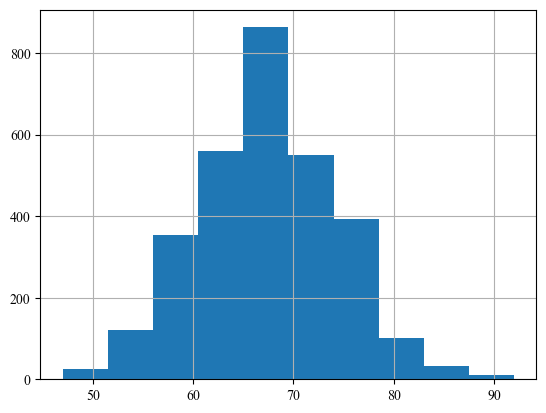

In [351]:
df['target'].hist()

In [352]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [353]:
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [354]:


# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')


# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [355]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


In [356]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


In [357]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Random Forest Regressor training----->


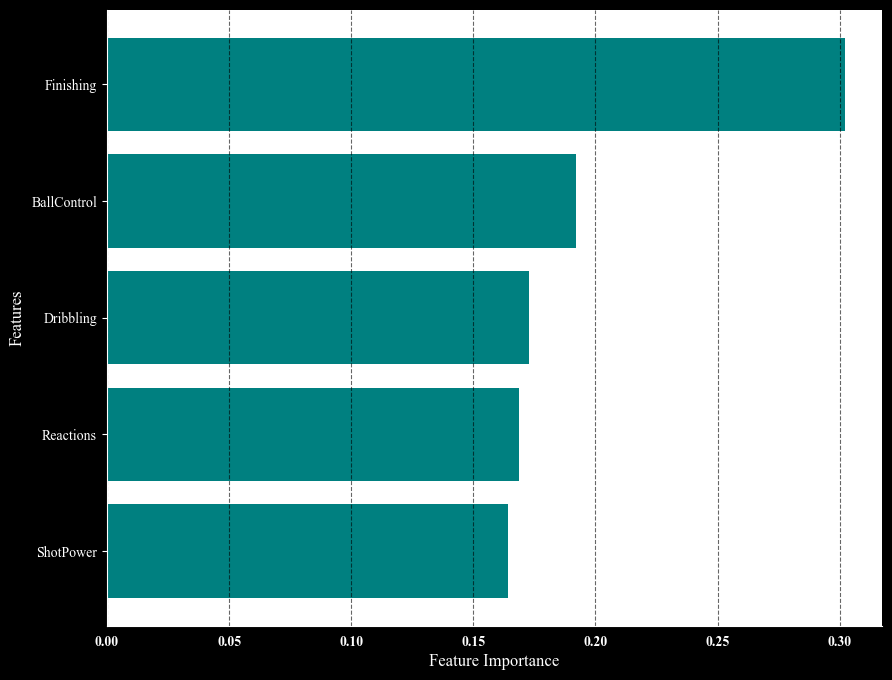

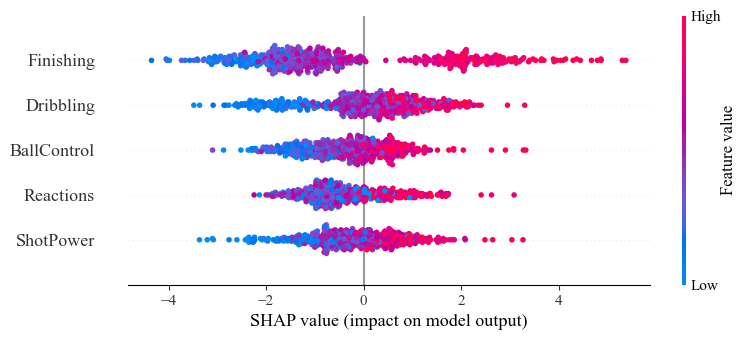

<Figure size 640x480 with 0 Axes>

              precision    recall  f1-score   support

       False       0.98      1.00      0.99       544
        True       0.00      0.00      0.00        11

    accuracy                           0.98       555
   macro avg       0.49      0.50      0.49       555
weighted avg       0.96      0.98      0.97       555

Gradient Boosting Regressor training----->


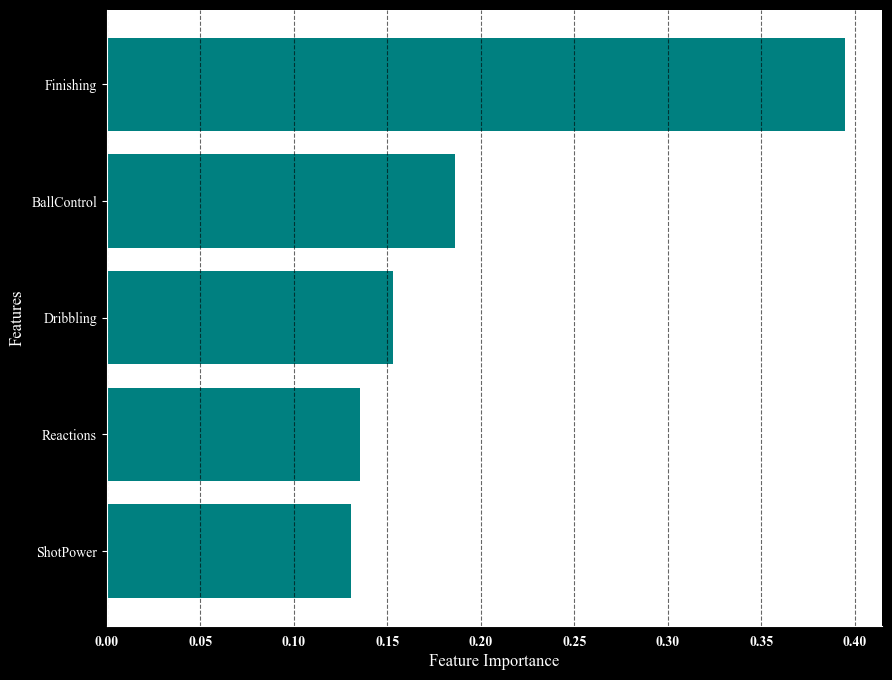

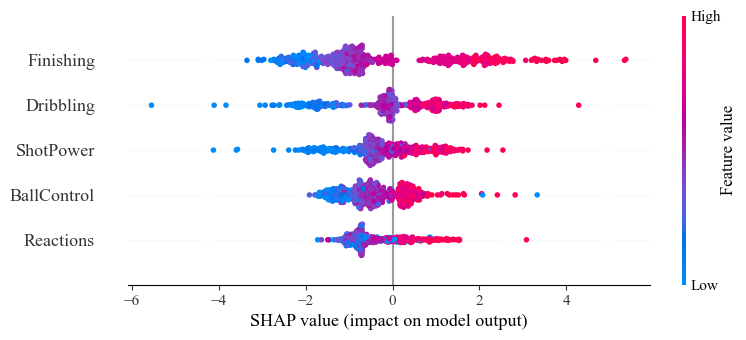

<Figure size 640x480 with 0 Axes>

              precision    recall  f1-score   support

       False       0.98      1.00      0.99       544
        True       0.00      0.00      0.00        11

    accuracy                           0.98       555
   macro avg       0.49      0.50      0.49       555
weighted avg       0.96      0.98      0.97       555

XGBoost Regressor training----->


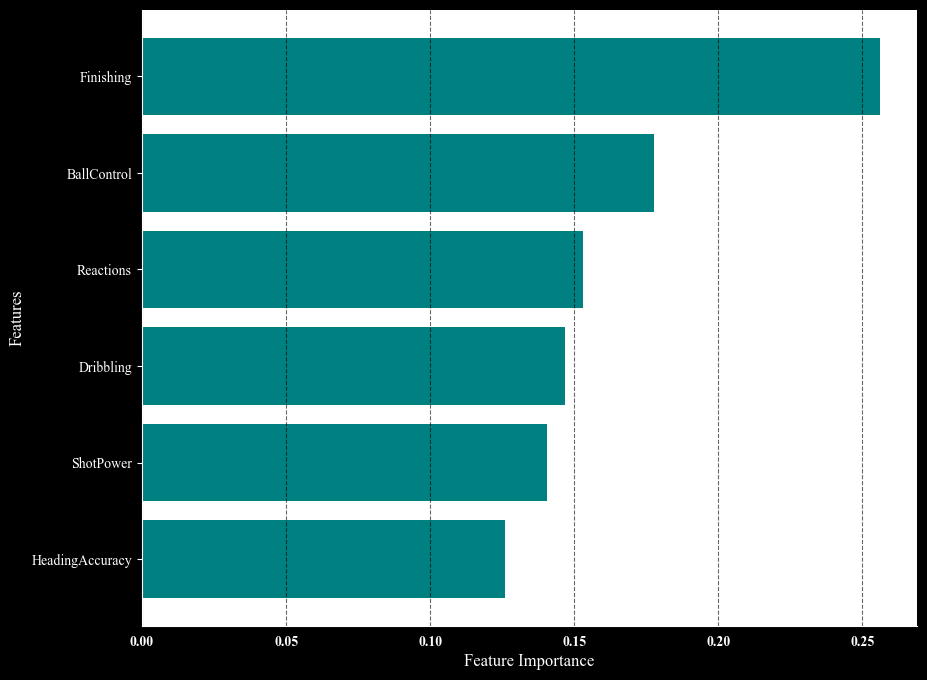

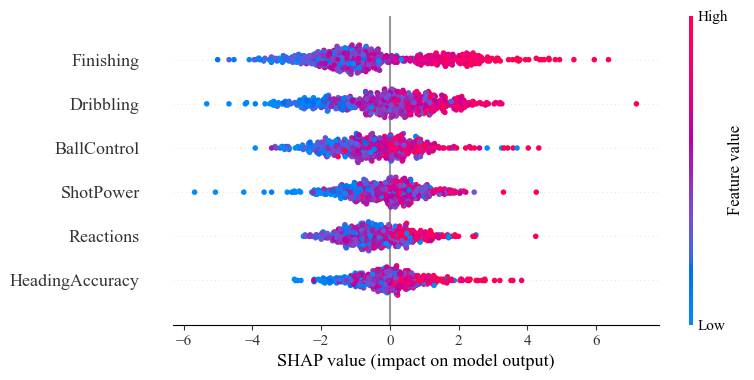

<Figure size 640x480 with 0 Axes>

              precision    recall  f1-score   support

       False       0.98      1.00      0.99       544
        True       0.00      0.00      0.00        11

    accuracy                           0.98       555
   macro avg       0.49      0.50      0.49       555
weighted avg       0.96      0.98      0.97       555

LightGBM Regressor training----->
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1101
[LightGBM] [Info] Number of data points in the train set: 1972, number of used features: 21
[LightGBM] [Info] Start training from score 68.042596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data point

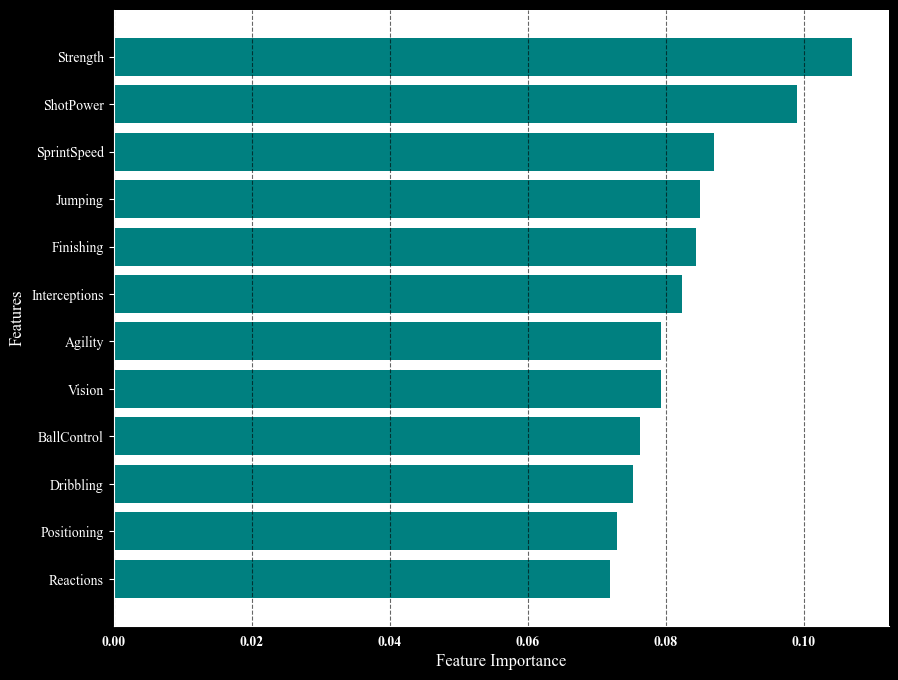

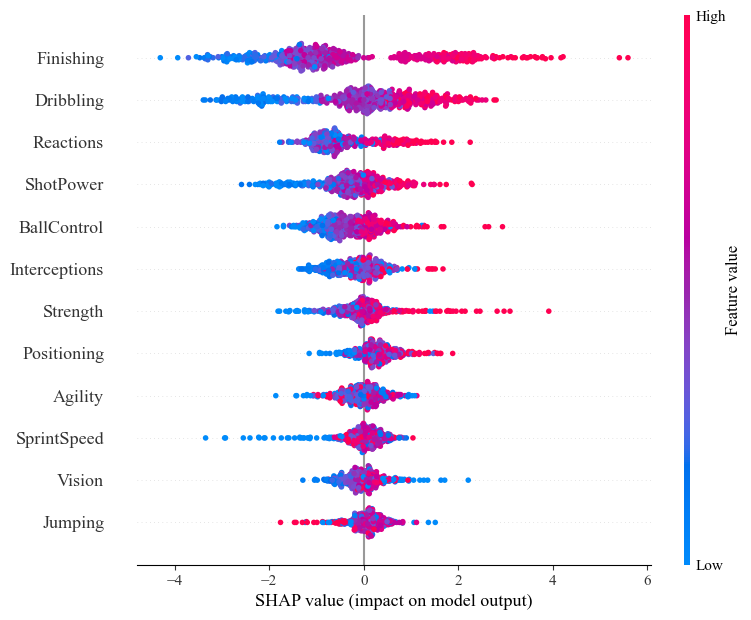

<Figure size 640x480 with 0 Axes>

              precision    recall  f1-score   support

       False       0.98      1.00      0.99       544
        True       0.50      0.09      0.15        11

    accuracy                           0.98       555
   macro avg       0.74      0.54      0.57       555
weighted avg       0.97      0.98      0.97       555

Model: Random Forest Regressor
Mean Squared Error: 26.82
Mean Absolute Error: 4.06
R2 Score: 0.32

Model: Gradient Boosting Regressor
Mean Squared Error: 24.40
Mean Absolute Error: 3.85
R2 Score: 0.38

Model: XGBoost Regressor
Mean Squared Error: 29.72
Mean Absolute Error: 4.22
R2 Score: 0.24

Model: LightGBM Regressor
Mean Squared Error: 28.18
Mean Absolute Error: 4.14
R2 Score: 0.28



In [358]:

import lightgbm as lgb

regression_models = {
    # 'Ridge Regression': Ridge(**PARAMS_RIDGE),
    # 'Huber Regression':HuberRegressor(),
    # # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # # 'Lasso Regression': Lasso(),
    # # 'ElasticNet Regression': ElasticNet(),
    # 'Linear Regression': LinearRegression(),
     'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
     'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
      'XGBoost Regressor': XGBRegressor(random_state=42),
    'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}

# Set the experiment name

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        features = select_features(method=AUTO_FEATURE_SELECT,X=X_train_scaled_df,y=y_train,model=model)
        
        model.fit(X_train_scaled_df[features], y_train)
        y_pred = model.predict(X_test_scaled_df[features])
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(features),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df[features])
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        explainer = plot_shap_summary(model=model,df=X_test_scaled_df[features],K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        

        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'explainer':explainer,
            'attributes': features,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [359]:

if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [360]:
X_train[X_train.Agility == 0]

,,,Crossing,Finishing,Composure,Interceptions,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,BallControl,...,Agility,Reactions,ShotPower,Jumping,Strength,Positioning,Vision,Age,Penalties,HeadingAccuracy
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,


In [361]:
X_train.describe()

,Crossing,Finishing,Composure,Interceptions,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,BallControl,...,Agility,Reactions,ShotPower,Jumping,Strength,Positioning,Vision,Age,Penalties,HeadingAccuracy
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,...,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,41.649087,61.890974,11.533469,25.166329,51.656694,52.250000,58.968053,46.536004,40.752535,59.056795,...,65.116126,57.307302,60.905172,63.225152,61.239351,40.088235,49.813895,19.434077,57.653651,57.121197
std,11.695424,7.362801,22.609728,9.636242,9.634376,10.052418,9.201366,11.053407,11.554061,8.969978,...,10.257774,8.751191,9.024778,10.456016,12.664324,27.485273,9.866555,1.633060,9.492138,9.570111
min,12.000000,29.000000,0.000000,10.000000,19.000000,23.000000,28.000000,17.000000,14.000000,22.000000,...,30.000000,26.000000,30.000000,25.000000,22.000000,0.000000,10.000000,16.000000,17.000000,22.000000
25%,32.000000,57.000000,0.000000,18.000000,45.000000,45.000000,53.000000,38.000000,32.000000,53.000000,...,58.000000,51.000000,54.000000,58.000000,53.000000,0.000000,44.000000,18.000000,52.000000,51.000000
50%,40.000000,62.000000,0.000000,24.000000,52.000000,52.000000,59.000000,45.000000,39.000000,59.000000,...,65.000000,56.000000,61.000000,64.000000,61.000000,52.000000,49.000000,19.000000,59.000000,57.000000
75%,50.000000,66.000000,0.000000,30.000000,59.000000,59.000000,65.000000,54.000000,48.000000,65.000000,...,72.000000,63.000000,67.000000,70.000000,71.000000,61.000000,56.000000,21.000000,64.000000,64.000000
max,77.000000,92.000000,82.000000,65.000000,82.000000,87.000000,92.000000,84.000000,81.000000,91.000000,...,95.000000,87.000000,87.000000,93.000000,94.000000,89.000000,84.000000,22.000000,92.000000,85.000000


In [362]:
y_test.describe()

count    555.000000
mean      66.554955
std        6.275716
min       50.000000
25%       62.000000
50%       67.000000
75%       70.000000
max       91.000000
Name: target, dtype: float64

In [363]:
my_model = regression_results['Gradient Boosting Regressor']['Model']
my_features = regression_results['Gradient Boosting Regressor']['attributes']


In [364]:
result_df = pd.Series(my_model.predict(X_test_scaled_df[my_features]),index=X_test_scaled_df.index)
len(result_df)

555

<Axes: >

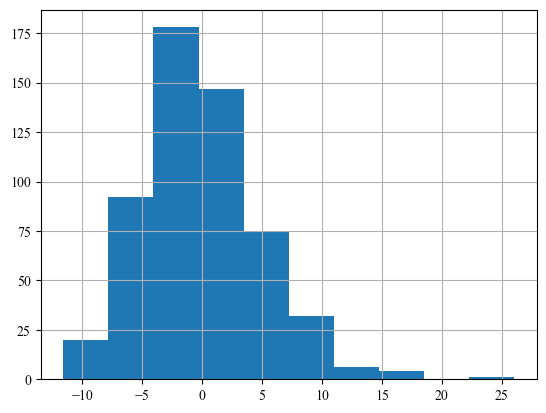

In [365]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

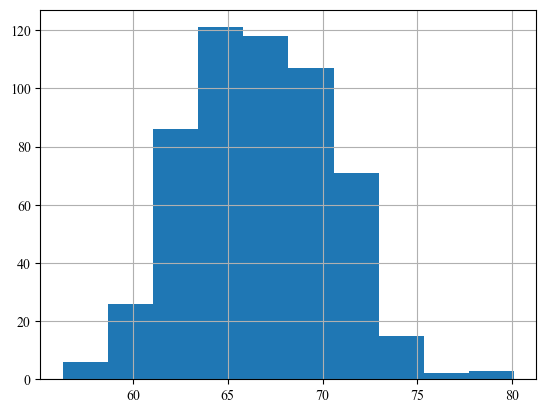

In [366]:
result_df.sort_values(ascending=False).hist()

In [367]:
(y_test-result_df).describe()

count    555.000000
mean      -0.098795
std        4.943390
min      -11.599806
25%       -3.576247
50%       -0.541245
75%        2.852153
max       26.037708
dtype: float64

# outlier detection

In [368]:
outlier = (y_test-result_df)>10
X_test[outlier]


,,,Crossing,Finishing,Composure,Interceptions,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,BallControl,...,Agility,Reactions,ShotPower,Jumping,Strength,Positioning,Vision,Age,Penalties,HeadingAccuracy
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
233731,A. Isak,2018,51.0,68.0,61.0,24.0,58.0,74.0,68.0,40.0,35.0,69.0,...,78.0,60.0,63.0,67.0,56.0,70.0,59.0,17.0,54.0,65.0
232293,V. Osimhen,2019,41.0,68.0,55.0,19.0,57.0,65.0,63.0,59.0,39.0,66.0,...,68.0,62.0,69.0,75.0,66.0,68.0,51.0,19.0,65.0,66.0
243580,I. Openda,2019,32.0,64.0,43.0,16.0,56.0,54.0,60.0,44.0,30.0,59.0,...,60.0,47.0,65.0,55.0,58.0,62.0,53.0,18.0,61.0,59.0
246430,D. Vlahovic,2020,41.0,65.0,55.0,12.0,60.0,47.0,55.0,41.0,37.0,55.0,...,55.0,54.0,62.0,65.0,63.0,58.0,53.0,19.0,65.0,62.0
245152,S. Giménez,2019,36.0,65.0,48.0,14.0,45.0,45.0,45.0,40.0,36.0,53.0,...,52.0,51.0,52.0,63.0,47.0,55.0,48.0,17.0,74.0,65.0
239085,E. Håland,2018,42.0,59.0,48.0,15.0,46.0,51.0,58.0,67.0,33.0,57.0,...,68.0,52.0,56.0,67.0,66.0,53.0,49.0,16.0,60.0,56.0
236461,J. Mateta,2018,31.0,63.0,54.0,14.0,50.0,56.0,52.0,42.0,27.0,56.0,...,56.0,52.0,63.0,73.0,80.0,58.0,52.0,20.0,61.0,74.0
241487,J. Ferreira,2019,26.0,58.0,45.0,17.0,49.0,40.0,55.0,31.0,27.0,54.0,...,77.0,52.0,51.0,62.0,39.0,53.0,46.0,17.0,57.0,44.0
241850,M. Retegui,2020,29.0,63.0,63.0,18.0,53.0,48.0,57.0,40.0,31.0,63.0,...,46.0,58.0,52.0,67.0,72.0,61.0,54.0,20.0,66.0,70.0


In [369]:
y_test[outlier]

ID      Name           FIFA
233731  A. Isak        2018    82.0
232293  V. Osimhen     2019    88.0
243580  I. Openda      2019    82.0
246430  D. Vlahovic    2020    84.0
245152  S. Giménez     2019    78.0
239085  E. Håland      2018    91.0
236461  J. Mateta      2018    78.0
241487  J. Ferreira    2019    76.0
241850  M. Retegui     2020    77.0
237679  R. Kolo-Muani  2019    84.0
225783  S. Mavididi    2018    76.0
247679  V. Boniface    2020    74.0
240243  Matheus Cunha  2018    81.0
244622  Puado          2019    78.0
238756  J. Larsen      2018    73.0
229375  E. Adebayo     2019    72.0
237619  S. Twine       2018    72.0
252324  Riquelme       2020    78.0
Name: target, dtype: float64

In [370]:
result_df[outlier]

ID      Name           FIFA
233731  A. Isak        2018    71.932487
232293  V. Osimhen     2019    71.684791
243580  I. Openda      2019    68.096672
246430  D. Vlahovic    2020    66.964132
245152  S. Giménez     2019    66.714555
239085  E. Håland      2018    64.962292
236461  J. Mateta      2018    65.928539
241487  J. Ferreira    2019    65.238401
241850  M. Retegui     2020    66.216308
237679  R. Kolo-Muani  2019    68.617411
225783  S. Mavididi    2018    61.410454
247679  V. Boniface    2020    63.710786
240243  Matheus Cunha  2018    64.781231
244622  Puado          2019    65.913362
238756  J. Larsen      2018    61.516467
229375  E. Adebayo     2019    61.283367
237619  S. Twine       2018    61.888431
252324  Riquelme       2020    67.878257
dtype: float64

In [371]:
(y_test/result_df).describe()

count    555.000000
mean       0.998421
std        0.075090
min        0.811691
25%        0.946789
50%        0.991742
75%        1.043124
max        1.400813
dtype: float64

In [372]:
(y_test/result_df).describe()

count    555.000000
mean       0.998421
std        0.075090
min        0.811691
25%        0.946789
50%        0.991742
75%        1.043124
max        1.400813
dtype: float64

In [373]:
np.corrcoef(y_test,result_df)

array([[1.        , 0.61634157],
       [0.61634157, 1.        ]])

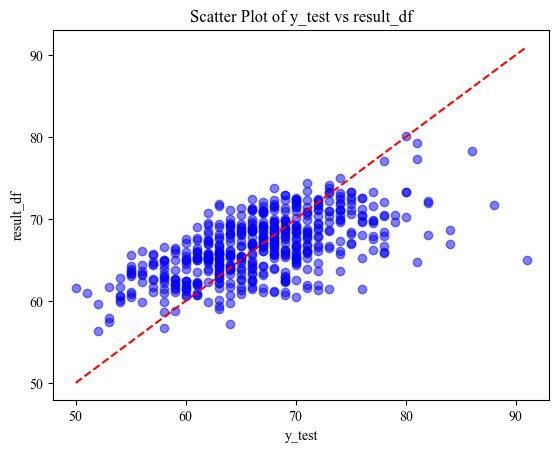

In [374]:

plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [375]:
result_df = result_df.sort_values(ascending=False)

In [376]:
sum(X_train_scaled_df.index.get_level_values('ID')==239085)

0

In [377]:
result_df.head(50)

ID      Name              FIFA
231447  D. Malen          2020    80.109205
243630  J. David          2020    79.227384
241721  Rafael Leão       2020    78.268168
236786  M. Terrier        2019    77.338007
226766  Daniel Podence    2018    77.059533
237539  L. Singh          2019    75.043905
251105  D. Joveljić       2020    74.355515
244628  B. Segovia        2019    74.190719
241301  J. Shonga         2019    73.750199
252037  Fábio Silva       2020    73.744035
240265  L. Juliš          2018    73.365020
243315  Dani Gómez        2020    73.347708
241026  T. Chancalay      2019    73.346524
246191  J. Álvarez        2020    73.338771
231184  Guruzeta          2019    73.320968
245940  S. Wamangituka    2020    73.320968
239207  M. Gómez          2018    73.252291
246690  A. Bareiro        2020    73.180360
239953  Léo Jabá          2018    73.142019
245762  A. Kutucu         2020    72.968431
239378  K. Sierhuis       2019    72.911271
239842  G. Giakoumakis    2018    72.752108
2

In [378]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

1


ID      Name      FIFA
231447  D. Malen  2020    80.109205
dtype: float64

In [379]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

14


ID      Name           FIFA
243630  J. David       2020    79.227384
241721  Rafael Leão    2020    78.268168
236786  M. Terrier     2019    77.338007
246191  J. Álvarez     2020    73.338771
239207  M. Gómez       2018    73.252291
246242  B. Dia         2020    72.242349
233731  A. Isak        2018    71.932487
232293  V. Osimhen     2019    71.684791
226710  G. Scamacca    2018    70.284098
237679  R. Kolo-Muani  2019    68.617411
243580  I. Openda      2019    68.096672
246430  D. Vlahovic    2020    66.964132
239085  E. Håland      2018    64.962292
240243  Matheus Cunha  2018    64.781231
dtype: float64

In [380]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

1


ID      Name      FIFA
231447  D. Malen  2020    80.109205
dtype: float64

In [381]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

540


ID      Name            FIFA
241522  J. Wind         2020    72.516389
245437  A. Gaich        2020    72.547368
239015  E. Dennis       2018    72.561705
246672  Barrenetxea     2020    72.745602
239842  G. Giakoumakis  2018    72.752108
239378  K. Sierhuis     2019    72.911271
245762  A. Kutucu       2020    72.968431
239953  Léo Jabá        2018    73.142019
246690  A. Bareiro      2020    73.180360
245940  S. Wamangituka  2020    73.320968
231184  Guruzeta        2019    73.320968
241026  T. Chancalay    2019    73.346524
243315  Dani Gómez      2020    73.347708
240265  L. Juliš        2018    73.365020
252037  Fábio Silva     2020    73.744035
241301  J. Shonga       2019    73.750199
244628  B. Segovia      2019    74.190719
251105  D. Joveljić     2020    74.355515
237539  L. Singh        2019    75.043905
226766  Daniel Podence  2018    77.059533
dtype: float64

In [382]:

print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.92      0.99      0.96       511
        True       0.33      0.05      0.08        44

    accuracy                           0.92       555
   macro avg       0.63      0.52      0.52       555
weighted avg       0.88      0.92      0.89       555



In [383]:
X_train[X_train.index.get_level_values('ID')==239085]

,,,Crossing,Finishing,Composure,Interceptions,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,BallControl,...,Agility,Reactions,ShotPower,Jumping,Strength,Positioning,Vision,Age,Penalties,HeadingAccuracy
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
